In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# The following list is the raw tick data for sim length
# 1 message is sent around the network, no failures
# To get seconds, divide each number by 1x10^6
sim_lengths = [11490430, 10003359, 13931034, 9337192, 11873662, 
              20700903, 70734350, 9723444, 36370158, 20700903]
print('Median:', np.median(sim_lengths), 'Mean:', np.mean(sim_lengths))
print('Std Dev:', np.std(sim_lengths))

('Median:', 12902348.0, 'Mean:', 21486543.5)
('Std Dev:', 18208127.76003491)


In [3]:
print(np.median(sim_lengths)/1000)

12902.348


In [66]:
import os
import re
import pandas as pd
import numpy as np

from collections import namedtuple
from functools import reduce
from pathlib2 import Path


exp_path = Path(os.getcwd(), 'experiments')
exp_re = re.compile(r'(?P<n>\d+)-(?P<t>\w+)-(?P<k>\d+)-(?P<imin>\d+)-(?P<imax>\d+)-(?P<d>\d+)-run(?P<r>\d)')
experiments = filter(lambda x: os.path.isdir(str(Path(exp_path, x))), os.listdir(str(exp_path)))


def parse_logfile(path):
    f = pd.read_csv(str(path), names=['time','msg'], header=None, delimiter=';')
    tx_count = 0
    token_val = -1
    
    for index, row in f.iterrows():
        text = row['msg']
        
        if 'Trickle TX' in text:
            tx_count += 1
        elif 'Current token' in text:
            token_val = int(re.match(r'.*Current\ token:\ (?P<n>\d+)', text).group('n'))
            
    return tx_count, token_val


Experiment = namedtuple('Experiment', ['d', 'k', 'imin', 'n', 't', 'imax'])
exp_dict = {}


for exp in experiments:
    exp_dir = Path(exp_path, exp)
    params = exp_re.match(exp).groupdict()
    params.pop('r', -1)
    
    experiment = Experiment(**params)
    
    files = filter(lambda x: "run" in x, os.listdir(str(exp_dir)))
    filename_re = re.compile(r'.*\_(?P<id>\d+)\.txt')
    
    experiment_dict = {}
    
    for f in files:
        node_id = filename_re.match(f).group('id')
        
        experiment_dict[node_id] = parse_logfile(Path(exp_dir, f))
    
    total_tx = 0
    total_has_token = 0
    for t in experiment_dict.values():
        total_tx += t[0]
        
        if t[1] == 1:
            total_has_token += 1
    
    if exp_dict.get(experiment):
        exp_dict[experiment].append((total_tx, (total_has_token / 49.0) * 100))
    else:
        exp_dict[experiment] = [(total_tx, (total_has_token / 49.0) * 100)]

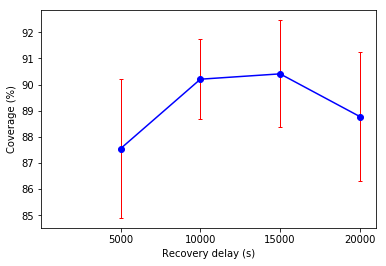

In [126]:
def filter_experiments(experiments, mask):
    # Mask is a namedtuple that has None for fields that are to be ignored
    mask_set = set(filter(lambda x: x[1], mask._asdict().items()))
    return filter(lambda x: mask_set <= set(x._asdict().items()), experiments)


coverage_delay_loc = filter_experiments(exp_dict.keys(), Experiment(d='', k='', imin='', n='10', t='location', imax=''))
coverage_delay_loc = sorted(coverage_delay_loc, key=lambda x: int(x.d))

d = []
cov = []
msg = []
cov_std = []
msg_std = []

for exp in coverage_delay_loc:
    msgs, coverage = [list(t) for t in zip(*exp_dict[exp])]
    
    d.append(int(exp.d))
    cov.append(np.mean(coverage))
    cov_std.append(np.std(coverage))
    msg.append(np.mean(msgs))
    msg_std.append(np.std(msgs))
    
plt.errorbar(d, cov, cov_std, ecolor='r', elinewidth=1, capsize=2, marker='o', color='b')
plt.xlim(0, 21000)
plt.xticks(d)
plt.ylabel('Coverage (%)')
plt.xlabel('Recovery delay (s)')
plt.show()
#     print(np.mean(msgs), np.mean(coverage), np.std(coverage), 'd=' + exp.d)